[*********************100%***********************]  1 of 1 completed


/var/folders/qz/cgmh9p817l9gz6hgwnfltj540000gn/T/ipykernel_78429/2041340648.py:48: DeprecationWarning: The 'label' keyword argument of 'Pauli' is deprecated as of Qiskit Terra 0.17 and will be removed in version 0.23 or later. Pass the label positionally instead, such as 'Pauli("XYZ")'.
  observable = PauliOp(Pauli(label="Z" * len(datum)))
/var/folders/qz/cgmh9p817l9gz6hgwnfltj540000gn/T/ipykernel_78429/2041340648.py:48: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_op.PauliOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  observable = PauliOp(Pauli(label="Z" * len(datum)))
/var/folders/qz/cgmh9p817l9gz6hgwnfltj540000gn/T/ipykernel_78429/2041340648.py:49: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months afte

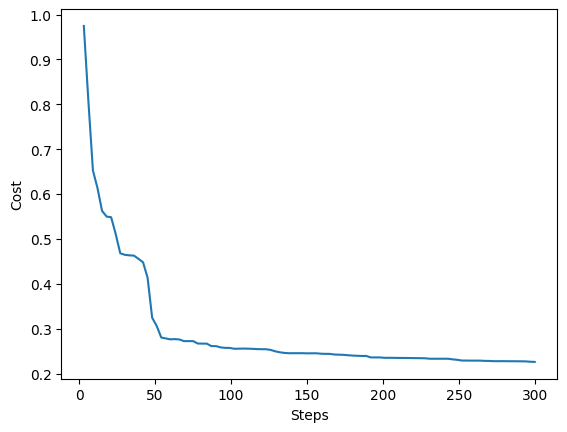

In [5]:
import yfinance as yf
import numpy as np
from qiskit import BasicAer
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.algorithms.optimizers import SPSA
from qiskit.opflow import PauliExpectation, CircuitStateFn, PauliOp, Z
from qiskit.quantum_info import Pauli
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

# Define quantum helper functions and classes
def parity(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight + 1) % 2

def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

class OptimizerLog:
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []

    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

def circuit_instance(data, params, feature_map, var_form):
    qc = QuantumCircuit(len(data))
    fm_bound = feature_map.bind_parameters({feature_map.parameters[i]: data[i] for i in range(len(data))})
    qc.append(fm_bound, range(len(data)))
    vf_bound = var_form.bind_parameters({var_form.parameters[i]: params[i] for i in range(len(params))})
    qc.append(vf_bound, range(len(data)))
    return qc

def cost_function(params, data, labels, feature_map, var_form):
    total_loss = 0
    for i, datum in enumerate(data):
        qc = circuit_instance(datum, params, feature_map, var_form)
        observable = PauliOp(Pauli(label="Z" * len(datum)))
        operator = CircuitStateFn(qc).adjoint().compose(observable).compose(CircuitStateFn(qc))
        expectation = PauliExpectation().convert(operator).eval().real
        total_loss += (expectation - labels[i]) ** 2
    return total_loss / len(data)

# Fetch and preprocess stock data
data = yf.download("AAPL", start="2021-09-01", end="2023-09-11")
data['Returns'] = data['Close'].pct_change()
data['Label'] = np.where(data['Returns'] > 0, 1, 0)
data = data.dropna()

normalized_close = (data['Close'].values - min(data['Close'].values)) / (max(data['Close'].values) - min(data['Close'].values)) * np.pi
normalized_returns = (data['Returns'].values - min(data['Returns'].values)) / (max(data['Returns'].values) - min(data['Returns'].values)) * np.pi
features_2D = np.column_stack((normalized_close, normalized_returns))

training_size = int(0.7 * len(data))
train_data = features_2D[:training_size]
train_labels = data['Label'][:training_size].values
test_data = features_2D[training_size:]
test_labels = data['Label'][training_size:].values

# Quantum setup
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

def wrapped_cost_function(params):
    return cost_function(params, train_data, train_labels, FEATURE_MAP, VAR_FORM)

log = OptimizerLog()
params = [0.01] * len(VAR_FORM.parameters)
objective = lambda params: wrapped_cost_function(params)
optimizer = SPSA(maxiter=100, callback=log.update)
result = optimizer.minimize(objective, x0=params) # Corrected this line

plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()


In [7]:
plt.show()

In [9]:
from qiskit import Aer, transpile, assemble
from qiskit.visualization import plot_histogram

# Initialize the simulator backend
backend = Aer.get_backend('qasm_simulator')

def quantum_prediction(data_point, optimized_params):
    # Construct the quantum circuit
    qc = circuit_instance(data_point, optimized_params, FEATURE_MAP, VAR_FORM)
    qc.measure_all() # Add measurement to all qubits

    # Execute the circuit
    tqc = transpile(qc, backend)
    qobj = assemble(tqc, shots=1024)
    result = backend.run(qobj).result()

    # Get the measurement results
    counts = result.get_counts()

    # Translate quantum results to predictions
    probs = label_probability(counts)
    
    # Decide the label: 1 if probability for label '1' is higher, else 0.
    prediction = 1 if probs[1] > 0.5 else 0
    
    return prediction

# Predict the labels for the test data
predicted_labels = [quantum_prediction(data_point, result.x) for data_point in test_data]

# Display the results
print(predicted_labels)


/var/folders/qz/cgmh9p817l9gz6hgwnfltj540000gn/T/ipykernel_78429/1097538811.py:15: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = backend.run(qobj).result()


[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]
